In [51]:
from zget_data import get_responses, get_qdetails, get_qinfo, get_questions, page_map, quest_map
from collections import defaultdict
import pandas as pd
import json

In [52]:
survey_response, time_response = get_responses()

# Time Analysis

,index,1,2,3,4,5,6,7,csquest,spasssurvey,demo,total (mins)
0,47.704,8.317,5.774,20.529,3.303,35.736,6.323,62.769,1143.746,75.336,75.957,24.758233
1,112.525,18.469,4.349,164.076,5.031,33.316,3.948,68.685,1014.168,145.120,280.664,30.839183
2,104.534,4.317,2.245,50.955,1.608,8.323,2.467,13.878,787.700,71.454,129.497,19.616300
3,63.538,11.205,3.537,25.954,3.870,22.020,7.220,79.719,1088.877,97.159,197.108,26.670117
4,40.725,5.459,4.329,25.462,4.268,33.700,2.059,51.148,897.312,51.163,75.270,19.848250
5,137.121,21.852,5.410,156.476,4.377,11.117,3.619,25.426,532.156,156.805,215.188,21.159117
6,79.991,16.422,2.722,98.089,6.139,25.421,4.338,20.372,932.172,68.971,132.821,23.124300
7,121.899,6.936,19.950,143.431,5.255,22.239,5.637,31.740,1094.535,132.327,250.360,30.571817
8,8.529,3.295,2.195,72.718,4.212,17.386,2.465,25.687,696.829,80.177,122.039,17.258867


23.76068703703704

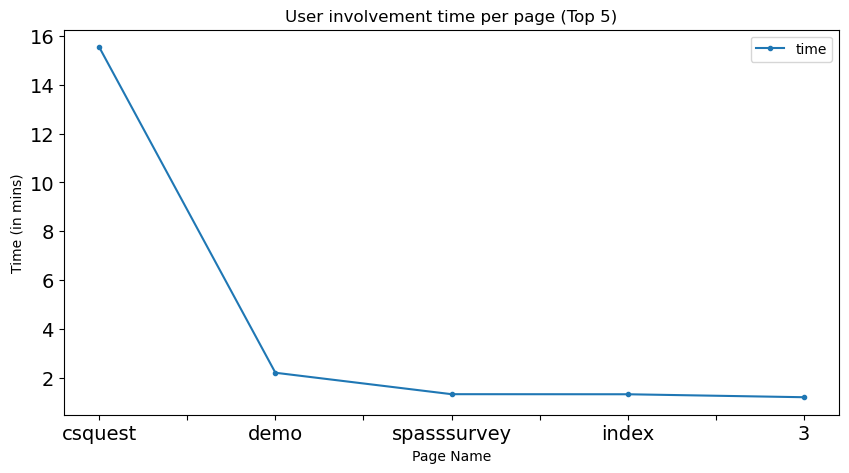

In [53]:
page_time_df = pd.DataFrame(time_response)
page_time_df = page_time_df.sort_index(axis=1, key=lambda x: x.astype(int))
page_time_df = page_time_df.rename(page_map, axis=1)
page_time_df['total (mins)'] = page_time_df.sum(axis=1)/60
display(page_time_df)
display(page_time_df['total (mins)'].mean())


# top 5 pages with higher time
top5 = pd.DataFrame(columns=['page', 'time'])
for i, data in page_time_df.median().div(60).sort_values(ascending=False).head(5).items():
    top5 = pd.concat([top5, pd.DataFrame([[i, data]], columns=top5.columns)])

_ = top5.plot(x='page', y='time', figsize=(10, 5), xlabel="Page Name", ylabel="Time (in mins)", title="User involvement time per page (Top 5)", fontsize=14, style=".-")

# Survey Response Analysis

In [54]:
questions = get_questions()
survey_response_df = pd.DataFrame(survey_response)
display(survey_response_df.head(1))

,8,9,0,10
0,"{'Sto': {'12-1': '2', '5-1': '6', '5-2': '5', ...","{'1-1': 'lrndsk!schl', '2-1': 'Strong', '3-1':...","{'1-1': ['Schoolwork', 'Assignments and homewo...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '..."


In [55]:
# Function to filter data based on page number
def test(d):
    temp = {}
    for k, v in d.items():
        for k2, v2 in v.items():
            q = f'{k2}_{k}'
            temp[q] = v2
    return temp

## CSQuest

In [56]:
csq_pid = '8'
csquest_response_df = survey_response_df[csq_pid].apply(test)
csquest_questions = get_questions().get(csq_pid)

csquest_response_df = pd.DataFrame(csquest_response_df.to_dict()).T
csquest_response_df.head(1)

,12-1_Sto,5-1_Sto,5-2_Sto,5-3_Sto,5-4_Sto,9-1_Sto,10-1_Sto,2-1_Sto,3-1_Sto,6-1_Sto,...,10-1_Bas,11-1_Bas,1-3_Bas,1-1_Bas,1-2_Bas,1-4_Bas,4-1_Sto,8-1_Sto,13-1_Sto,11-1_Sto
0,2,6,5,7,6,5,7,4,5,5,...,7,3rd design because it shows how in different s...,4,5,6,7,NaN,NaN,NaN,NaN


In [57]:
qualqsid = ['4-1', '8-1', '11-1', '13-1']
quantqsid = ['1-1', '1-2', '1-3', '1-4', '2-1', '3-1', '5-1', '5-2', '5-3', '5-4', '6-1', '7-1', '9-1', '10-1']
dnames = ['Sto', 'Cus', 'Bas']

qualcolumns = [f'{qsid}_{dname}' for qsid in qualqsid for dname in dnames]
quantcolumns = [f'{qsid}_{dname}' for qsid in quantqsid for dname in dnames]

### Qualitative Analysis/Export

In [58]:
qualcolumns_filtered = list(set(csquest_response_df.columns).intersection(qualcolumns))
csquest_qual_df = csquest_response_df[qualcolumns_filtered]

In [59]:
prefixes = set(col.split('_')[0] for col in csquest_qual_df.columns)

# Combine columns based on the common prefixes
for prefix in prefixes:
    matching_columns = [col for col in csquest_qual_df.columns if col.startswith(prefix)]
    combined_column_name = prefix.split('-')[0]
    csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    csquest_qual_df = csquest_qual_df.drop(columns=matching_columns)

# Function to remove nan_ from the beginning and _nan from the end
def remove_prefix_suffix(value):
    if pd.notna(value):
        value = str(value)
        if value.startswith('nan_'):
            value = value[4:]
        if value.endswith('_nan'):
            value = value[:-4]
    return value

# Apply the function to each element in the DataFrame
csquest_qual_df = csquest_qual_df.applymap(remove_prefix_suffix)
csquest_qual_df.to_csv('data/qualitative/csquest.csv', index=False)

/tmp/ipykernel_261544/2267720930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


### Quantitative Analysis

In [60]:
csquest_quant_df = csquest_response_df[quantcolumns].astype(int)
norm_csquest_quant_df = csquest_quant_df.sub(4)
norm_csquest_quant_df.head(1)

,1-1_Sto,1-1_Cus,1-1_Bas,1-2_Sto,1-2_Cus,1-2_Bas,1-3_Sto,1-3_Cus,1-3_Bas,1-4_Sto,...,6-1_Bas,7-1_Sto,7-1_Cus,7-1_Bas,9-1_Sto,9-1_Cus,9-1_Bas,10-1_Sto,10-1_Cus,10-1_Bas
0,2,0,1,1,0,2,-1,1,0,3,...,1,3,3,3,1,1,1,3,3,3


In [61]:
norm_sto_df = norm_csquest_quant_df.filter(like='Sto')
norm_cus_df = norm_csquest_quant_df.filter(like='Cus')
norm_bas_df = norm_csquest_quant_df.filter(like='Bas')

In [62]:
condition = '1-|5-'
new_norm_sto_df = norm_sto_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

temp = norm_sto_df.filter(like='1-')
new_norm_sto_df['1'] = temp.T.mean()

temp = norm_sto_df.filter(like='5-')
new_norm_sto_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

display(new_norm_sto_df)


condition = '1-|5-'
new_norm_cus_df = norm_cus_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

temp = norm_cus_df.filter(like='1-')
new_norm_cus_df['1'] = temp.T.mean()

temp = norm_cus_df.filter(like='5-')
new_norm_cus_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

display(new_norm_cus_df)


condition = '1-|5-'
new_norm_bas_df = norm_bas_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

temp = norm_bas_df.filter(like='1-')
new_norm_bas_df['1'] = temp.T.mean()

temp = norm_bas_df.filter(like='5-')
new_norm_bas_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

display(new_norm_bas_df)


,2,3,6,7,9,10,1,5
0,0,1,1,3,1,3,1.25,2.00
1,2,2,3,2,3,2,2.25,3.00
2,2,1,3,2,3,2,0.50,1.25
3,2,3,3,3,2,3,1.75,2.25
4,3,0,3,3,3,3,2.25,2.50
5,3,3,3,3,3,3,2.25,3.00
6,2,2,2,2,2,2,1.50,0.75
7,3,3,3,3,3,2,3.00,2.75
8,1,2,2,2,3,2,0.50,2.50


,2,3,6,7,9,10,1,5
0,1,0,1,3,1,3,0.75,2.00
1,3,3,3,3,3,3,1.75,3.00
2,2,3,2,3,3,3,2.00,2.25
3,2,2,1,2,3,3,1.50,3.00
4,2,1,3,2,3,3,1.75,2.25
5,0,3,0,3,3,3,2.00,3.00
6,1,1,1,1,0,-1,1.50,1.25
7,2,3,3,3,3,3,2.75,2.75
8,2,1,2,2,2,2,1.75,2.75


,2,3,6,7,9,10,1,5
0,0,1,1,3,1,3,1.50,2.00
1,3,2,2,2,3,2,2.75,2.75
2,2,2,1,3,3,1,2.25,2.00
3,2,1,1,2,2,3,1.25,2.25
4,0,3,3,3,3,3,1.75,3.00
5,0,0,0,3,3,3,0.00,3.00
6,3,3,2,2,1,3,2.50,2.25
7,2,3,3,3,3,3,2.75,2.75
8,2,1,3,3,3,3,1.00,2.75


In [63]:
display(pd.DataFrame(new_norm_sto_df.mean()).T)
display(pd.DataFrame(new_norm_cus_df.mean()).T)
display(pd.DataFrame(new_norm_bas_df.mean()).T)

,2,3,6,7,9,10,1,5
0,2.0,1.888889,2.555556,2.555556,2.555556,2.444444,1.694444,2.222222


,2,3,6,7,9,10,1,5
0,1.666667,1.888889,1.777778,2.444444,2.333333,2.444444,1.75,2.472222


,2,3,6,7,9,10,1,5
0,1.555556,1.777778,1.777778,2.666667,2.444444,2.666667,1.75,2.527778


In [64]:
get_qinfo(8, 1)

'Aesthetics'